In [1]:
import numpy as np

import time
import sys

from matplotlib import pyplot as plt

### Redshift-Space Distortions in LPT ###

Example of how to use the code to compute the redshift-space power spectrum in LPT.

The first step is to import the LPT_RSD class and initialize it.  The first time this is run it can be a bit slow, but once this has been run the first time on a given platform you can save the 'wisdom' file that FFTW uses and this will speed up further executions (using the `export_wisdom` method of MomentExpansion).

Let's start with the LPT code:

In [2]:
from LPT.lpt_rsd_fftw import LPT_RSD

In [3]:
# To match the plots in Chen, Vlah & White (2020) let's
# work at z=0.8, and scale our initial power spectrum
# to that redshift:
z,D,f      = 0.8, 0.6819, 0.8076
klin,plin  = np.loadtxt("pk.dat",unpack=True)
plin      *= D**2

In [4]:
# Initialize the class -- with no wisdom file passed it will
# experiment to find the fastest FFT algorithm for the system.
start= time.time()
lpt = LPT_RSD(klin,plin,kIR=0.2)
print("Elapsed time: ",time.time()-start," seconds.")
# You could save the wisdom file here if you wanted:
# mome.export_wisdom(wisdom_file_name)

Elapsed time:  0.640092134475708  seconds.


We'll start with how to compute $P(k,\mu)$ given a linear theory $P(k)$ file:

In [5]:
# Set up some fiducial values for the parameters -- we'll use the
# same paramters as in the paper

# pars: the biases and counter terms.
# b1,b2,bs, b3: linear, quadratic & cubic parameters
# alpha0,alpha2,alpha4: counterterms
# sn,s0: stochastic contributions to P(k) and sigma^2.

biases = [0.71,0.26,0.67,0.52]
cterms = [-3.4,-1.7,6.5,0]
stoch  = [1500.,-1900.,0]
pars   = biases + cterms + stoch
#
# Compute the wedges, here we'll just to a single mu.  Note if we
# just wanted the real-space power spectrum we could pass mu=0 to
# compute_redshift_space_power_at_mu.  Here we'll do mu=0.5:
mu     = 0.5
start  = time.time()
lpt.make_ptable(f,mu)
kw, pw = lpt.combine_bias_terms_pkmu(mu,pars)
print("Elapsed time: ",time.time()-start," seconds.")

Elapsed time:  0.7709670066833496  seconds.


In [6]:
print("# First few k bins for mu=",mu)
print("# {:>10s} {:>12s}".format("k","P(k,mu)"))
for k,p in zip(kw[:10],pw[:10]):
    print("{:12.4e} {:12.4e}".format(k,p))

# First few k bins for mu= 0.5
#          k      P(k,mu)
  1.0000e-02   4.8977e+04
  1.0679e-02   4.9930e+04
  1.1404e-02   5.0755e+04
  1.2178e-02   5.1428e+04
  1.3005e-02   5.1933e+04
  1.3888e-02   5.2250e+04
  1.4831e-02   5.2360e+04
  1.5838e-02   5.2246e+04
  1.6914e-02   5.1890e+04
  1.8062e-02   5.1280e+04


And now let's look at the (even) multipoles, $P_{\ell}(k)$:

In [7]:
# It's about as easy to compute the multipole moments up to ell=4:
# You can add AP distortions by setting apar, aperp not equal to unity
start       = time.time()
lpt.make_pltable(f,nmax=4,apar=1,aperp=1)
kl,p0,p2,p4 = lpt.combine_bias_terms_pkell(pars)
print("Elapsed time: ",time.time()-start," seconds.")

Elapsed time:  2.3542721271514893  seconds.


In [8]:
print("# First few k bins for multipoles")
print("# {:>10s} {:>12s} {:>12s} {:>12s}".format("k","P0","P2","P4"))
for k,mono,quad,hexa in zip(kl[:10],p0[:10],p2[:10],p4[:10]):
    print("{:12.4e} {:12.4e} {:12.4e} {:12.4e}".format(k,mono,quad,hexa))

# First few k bins for multipoles
#          k           P0           P2           P4
  1.0000e-02   5.3056e+04   2.8273e+04   1.8832e+03
  1.0679e-02   5.4088e+04   2.8828e+04   1.9175e+03
  1.1404e-02   5.4980e+04   2.9303e+04   1.9461e+03
  1.2178e-02   5.5708e+04   2.9684e+04   1.9679e+03
  1.3005e-02   5.6252e+04   2.9961e+04   1.9824e+03
  1.3888e-02   5.6590e+04   3.0120e+04   1.9887e+03
  1.4831e-02   5.6704e+04   3.0152e+04   1.9862e+03
  1.5838e-02   5.6572e+04   3.0045e+04   1.9741e+03
  1.6914e-02   5.6178e+04   2.9790e+04   1.9518e+03
  1.8062e-02   5.5507e+04   2.9380e+04   1.9190e+03


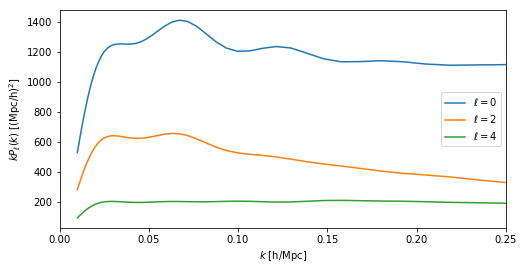

In [9]:
plt.figure(figsize=(8,4))

plt.plot(kl, kl*p0, label=r'$\ell = 0$')
plt.plot(kl, kl*p2, label=r'$\ell = 2$')
plt.plot(kl, 5*kl*p4, label=r'$\ell = 4$')

plt.xlim(0,0.25)
plt.ylabel(r'$k P_\ell(k)$ [(Mpc/h)$^2$]')
plt.xlabel(r'$k$ [h/Mpc]')
plt.legend()

plt.show()

You can also specify a fixed set of bias parameters and get configuration space multipoles.
(More documentation to come.)

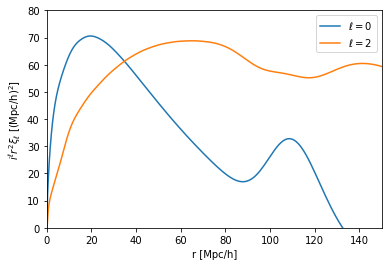

In [10]:
# Set stochastic parameters to zero because they make delta functions in config space
biases = [0.71,0.26,0.67,0.52]
cterms = [-3.4,-1.7,6.5,0]
stoch  = [0, 0, 0]
pars   = biases + cterms + stoch

xi0, xi2, xi4 = lpt.make_xiell_fixebias(f,pars)

plt.plot(xi0[0], xi0[0]**2 * xi0[1], label=r'$\ell = 0$')
plt.plot(xi2[0], -xi2[0]**2 * xi2[1], label=r'$\ell = 2$')

plt.xlabel(r'r [Mpc/h]')
plt.ylabel(r'$i^\ell r^2 \xi_\ell$ [(Mpc/h)$^2$]')
plt.legend()

plt.xlim(0,150)
plt.ylim(0,80)
plt.show()